
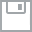
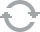
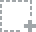
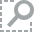
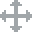
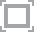
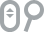
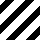
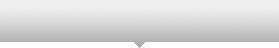
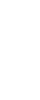
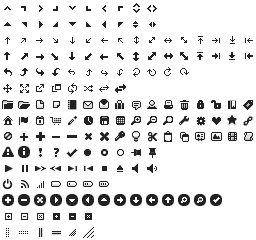
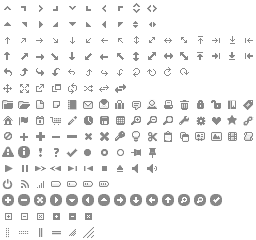
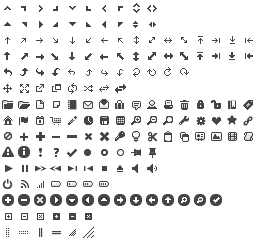
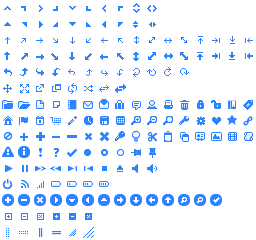
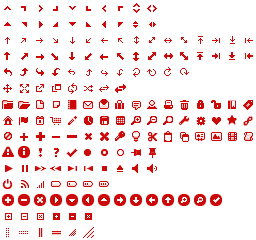
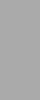
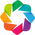
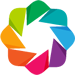

In [1]:
from bokeh.io import output_notebook, show
output_notebook()

In [2]:
import pandas as pd
import numpy as np
from IPython.display import display, HTML

In [3]:
from bokeh.palettes import Blues9
from bokeh.models import (
    BoxZoomTool,
    ColumnDataSource,
    CustomJS,
    HoverTool,
    Patches,
    Plot,
    Range1d,
    ResetTool,
    Slider
)
from bokeh.io import vplot, file_html
from bokeh.resources import INLINE
from jinja2 import Template

In [4]:
map_data = pd.read_hdf('../../cgetools/data/province_map_data_simplified.hdf', 'df')
map_data.sort('alpha', inplace=True)
data = pd.read_csv('../../cgetools/data/sample_data_by_year.csv')
all_data = map_data.merge(data)
print(len(all_data) == len(map_data))

def color_data(data, columns_to_colorify, data_min=None, data_max=None, palette=Blues9):
    # data - the data frame which you are adding colored values to
    # columns_to_colorify - a list of strings which select the columns
    
    if data_min is None:
        num_only = data[columns_to_colorify]
        global_min = num_only.min().min()
        data_min = np.floor(global_min)

    if data_max is None:
        num_only = data[columns_to_colorify]
        global_max = num_only.max().max()
        data_max = np.ceil(global_max)
    
    data_range = data_max - data_min
    bin_factor = data_range / len(palette)
    
    def _get_color(value, palette):
        index = int(value / bin_factor)
        return palette[index - 1]

    for column_name in columns_to_colorify:
        color_name = '%s_color' % column_name
        data[color_name] = data['%s' % column_name].apply(_get_color, args=([palette]))
    return data

colored_data = color_data(all_data, [str(x) for x in range(1990, 2015)])
colored_data['active_year'] = 1990
colored_data['active_value'] = colored_data['1990']
colored_data['active_color'] = colored_data['1990_color']

True


In [16]:
def get_slider(source, length):
    callback = CustomJS(code="""
        var year = cb_obj.get('value');
        var data = source.get('data');
        var i = %d;
        data['active_color'] = data[year + '_color'];
        data['active_value'] = data[year];
        while (--i >= 0) {
            data['active_year'][i] = year;  // Instead of doing this I'd like to be able to change the hover tool 
        }
        source.trigger('change');
        """ % length)
    slider = Slider(start=1990, end=2015, value=1, step=1, title="Year", callback=callback)
    callback.args = {
        'source': source
    }
    return slider

def add_hover(plot, renderer):
    tooltips = "<span class='tooltip-text year'>@active_year</span>"                   
    tooltips += "<span class='tooltip-text country'>@name_en</span>"               
    tooltips += "<span class='tooltip-text value'>@active_value</span>"                                
    plot.add_tools(HoverTool(tooltips=tooltips, renderers=[renderer]))
    return plot

In [18]:
background_data = pd.read_hdf('../../cgetools/data/ne_50m_admin_0_europe_asia.hdf', 'df')

def build_interactive_map(data_frame, plot_width=600, x_range=[70, 140], y_range=[10, 60], title=""):
    aspect_ratio = (x_range[1] - x_range[0]) / (y_range[1] - y_range[0])
    plot_height = int(plot_width / aspect_ratio)
    x_range = Range1d(x_range[0], x_range[1])
    y_range = Range1d(y_range[0], y_range[1])
    plot = Plot(
        x_range=x_range, 
        y_range=y_range, 
        title=title, 
        plot_width=plot_width, 
        plot_height=plot_height, 
        background_fill='powderblue',
        outline_line_color=None,
        responsive=True
    )
    plot.add_tools(BoxZoomTool(), ResetTool())

    provinces = Patches(
        xs='xs', ys='ys', fill_color='active_color', line_color='#CCCCCC', line_width=0.5
    )
    countries = Patches(
        xs='xs', ys='ys', fill_color='lightgrey', line_color='grey', line_width=0.5
    )
    source = ColumnDataSource(data_frame)
    plot.add_glyph(ColumnDataSource(background_data), countries)
    renderer = plot.add_glyph(source, provinces)
    plot = add_hover(plot, renderer)
    slider = get_slider(source, len(data_frame))
    return vplot(plot, slider)

show(build_interactive_map(colored_data, plot_width=900))